In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob, os, time
start_time = time.time()
import fabio, pyFAI
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

(960, 578)
EDF_DataBlockID :  0.Image.Psd
EDF_BinarySize :  4439040
EDF_HeaderSize :  1536
ByteOrder :  LowByteFirst
DataType :  DoubleValue
Dim_1 :  578
Dim_2 :  960
Image :  0
HeaderID :  EH:000000:000000:000000
Size :  4439040
VersionNumber :  1
Epoch :  1481332406.5250968933
det_sample_dist :  0
y_beam :  0
x_beam :  0
Lambda :  0.495938
offset :  0
count_time :  120
point_no :  66
scan_no :  906
preset :  0
col_end :  559
col_beg :  0
row_end :  959
row_beg :  0
counter_pos :  120 2647 175 14.9682 0 88.8742 14.9682 0 25 25 1791 9.11272e+09 0 0 0 174.849 0 0 14.9682
counter_mne :  sec vct1 vct2 vct3 vct4 Imach pseudoC pfoil Emono Ecod img roi1 roi2 roi3 roi4 pico1 pico2 pico3 pico4
motor_pos :  65.9999 0.081186 89.9909 -89.9917 -0.0027 0.0021 57.1227 134.747 -32.9503 0.16656 -5 0.47558 -1.5 0 0 0 4.53604 0.1417 1.04 1.04022 1.04022 -4.4 -1.10211 -0.543725 -9.962 -14.038 -16.865 -7.195 24 -2.038 24.06 4.835 1
motor_mne :  del eta chi phi nu mu keta kap kphi tsx tsy tsz rox roy tox t

<IPython.core.display.Javascript object>


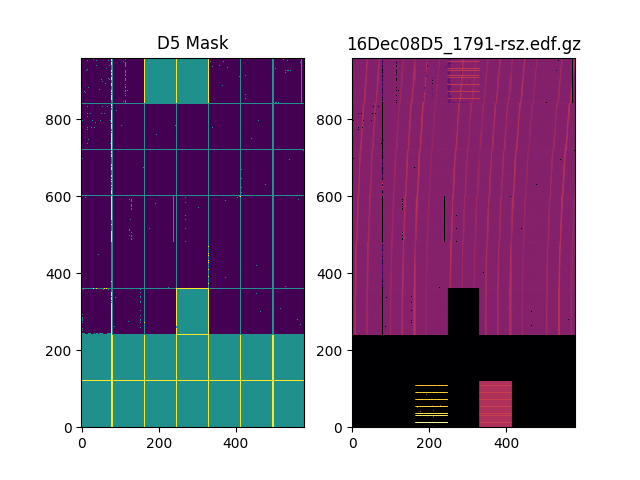

In [3]:
d5 = pyFAI.detector_factory("D5Geom.h5")
print(d5.shape)

images = glob.glob("*.edf.gz")
fimg = fabio.open(images[-1])

for k,v in fimg.header.items():
    print(k, ": ", v)
    
f,ax=subplots(1,2)
ax[0].imshow(d5.mask, origin="lower")
ax[0].set_title("D5 Mask")
ax[1].imshow(numpy.arcsinh(fimg.data), cmap="inferno", origin="lower")
ax[1].set_title(fimg.filename)


In [4]:
#Define wavelength and create our "large" LaB6 calibrant
wavelength = 0.495938 * 1e-10
from pyFAI.calibrant import Cell, Calibrant
c = Cell.cubic(4.1568260) 
c.save("LaB6", dmin=0.2)
LaB6 = Calibrant("LaB6.D")
LaB6.wavelength = wavelength
print("2theta max: ", numpy.degrees(LaB6.get_2th()[-1]))
print("Number of reflections: ", len(LaB6.get_2th()))

2theta max:  179.173497672
Number of reflections:  236


In [5]:
#Use a few manually calibrated images:
npt_files = [ i for i in glob.glob("*.npt") if "new" not in i]
npt_files.sort()
npt_files[0]
print("Number of hand-calibrated images :",len(npt_files))

Number of hand-calibrated images : 15


In [6]:
#Definition of the goniometer translation function:
# The detector rotates vertically, around the horizontal axis, i.e. rot2

goniotrans = GeometryTransformation(param_names = ["dist", "poni1", "poni2", 
                                                   "rot1", "rot2", "rot3", "scale1", "scale2" ],
                                    dist_expr="dist", 
                                    poni1_expr="poni1",
                                    poni2_expr="poni2", 
                                    rot1_expr="scale1 * pos +rot1", 
                                    rot2_expr="scale2 * pos + rot2", 
                                    rot3_expr="rot3")


#Definition of the function reading the goniometer angle from the filename of the image.

def get_angle(metadata):
    """Takes the angle from the first motor position and returns the angle of the goniometer arm"""
    return float(metadata["motor_pos"].split()[0])

print('filename', fimg.filename, "angle:",get_angle(fimg.header))

filename 16Dec08D5_1791-rsz.edf.gz angle: 65.9999


In [7]:
#Definition of the geometry refinement: the parameter order is the same as the param_names
rot3 = 0
scale1 = -numpy.pi/180
scale2 = 0
param = {"dist":0.5, 
         "poni1":0.05, 
         "poni2":0.05, 
         "rot1":0,
         "rot2":0,
         "rot3": rot3,
         "scale1": scale1,
         "scale2": scale2,
        }
#Defines the bounds for some variables
bounds = {"dist": (0.2, 0.8), 
          "poni1": (0, 0.1),
          "poni2": (0, 0.1),
          "rot1": (-0.1, 0.1),
          "rot2": (-0.1, 0.1),
          "rot3": (rot3, rot3), #strict bounds on rot3
          #"scale1": (scale1, scale1),
          #"scale2": (scale2, scale2),
         }
gonioref = GoniometerRefinement(param, #initial guess
                                bounds=bounds,
                                pos_function=get_angle,
                                trans_function=goniotrans,
                                detector=d5, wavelength=wavelength)
print("Empty refinement object:", gonioref)

#Let's populate the goniometer refinement object with all control point files:

for fn in npt_files[:]:
    base = os.path.splitext(fn)[0]
    fimg = fabio.open(base + ".edf.gz")
    sg =gonioref.new_geometry(base, image=fimg.data, metadata=fimg.header, control_points=fn, calibrant=LaB6)
    print(base, "Angle:", sg.get_position())
    

print("Filled refinement object:")
print(gonioref)

Empty refinement object: GoniometerRefinement with 0 geometries labeled: .
16Dec08D5_1725-rsz Angle: -0.003
16Dec08D5_1726-rsz Angle: 0.9998
16Dec08D5_1727-rsz Angle: 2.0
16Dec08D5_1728-rsz Angle: 2.9998
16Dec08D5_1729-rsz Angle: 4.0002
16Dec08D5_1730-rsz Angle: 4.9998
16Dec08D5_1735-rsz Angle: 10.0001
16Dec08D5_1742-rsz Angle: 16.9996
16Dec08D5_1749-rsz Angle: 24.0001
16Dec08D5_1756-rsz Angle: 30.9997
16Dec08D5_1763-rsz Angle: 37.9999
16Dec08D5_1770-rsz Angle: 44.9997
16Dec08D5_1777-rsz Angle: 52.0
16Dec08D5_1784-rsz Angle: 58.9995
16Dec08D5_1791-rsz Angle: 65.9999
Filled refinement object:
GoniometerRefinement with 15 geometries labeled: 16Dec08D5_1725-rsz, 16Dec08D5_1726-rsz, 16Dec08D5_1727-rsz, 16Dec08D5_1728-rsz, 16Dec08D5_1729-rsz, 16Dec08D5_1730-rsz, 16Dec08D5_1735-rsz, 16Dec08D5_1742-rsz, 16Dec08D5_1749-rsz, 16Dec08D5_1756-rsz, 16Dec08D5_1763-rsz, 16Dec08D5_1770-rsz, 16Dec08D5_1777-rsz, 16Dec08D5_1784-rsz, 16Dec08D5_1791-rsz.


In [8]:
# Initial refinement of the goniometer model with 5 dof

gonioref.refine2()


Cost function before refinement: 0.000307661216084
     fun: 1.985522551645608e-08
     jac: array([  2.40910207e-08,   3.04895212e-07,   4.13678287e-07,
        -1.75558109e-07,  -9.57393767e-07,   3.19744231e-14,
        -5.24527095e-06,  -7.14980806e-07])
 message: 'Optimization terminated successfully.'
    nfev: 178
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([  5.20464974e-01,   6.34779274e-02,   4.46077058e-02,
         3.03313916e-03,   7.46909753e-03,   0.00000000e+00,
        -1.74719084e-02,  -3.84262988e-04])
Cost function after refinement: 1.985522551645608e-08
GonioParam(dist=0.52046497446958784, poni1=0.063477927411335899, poni2=0.044607705770668513, rot1=0.0030331391649441575, rot2=0.0074690975275068872, rot3=0.0, scale1=-0.01747190844436023, scale2=-0.0003842629880195657)
maxdelta on: dist (0) 0.5 --> 0.52046497447


array([  5.20464974e-01,   6.34779274e-02,   4.46077058e-02,
         3.03313916e-03,   7.46909753e-03,   0.00000000e+00,
        -1.74719084e-02,  -3.84262988e-04])

<IPython.core.display.Javascript object>


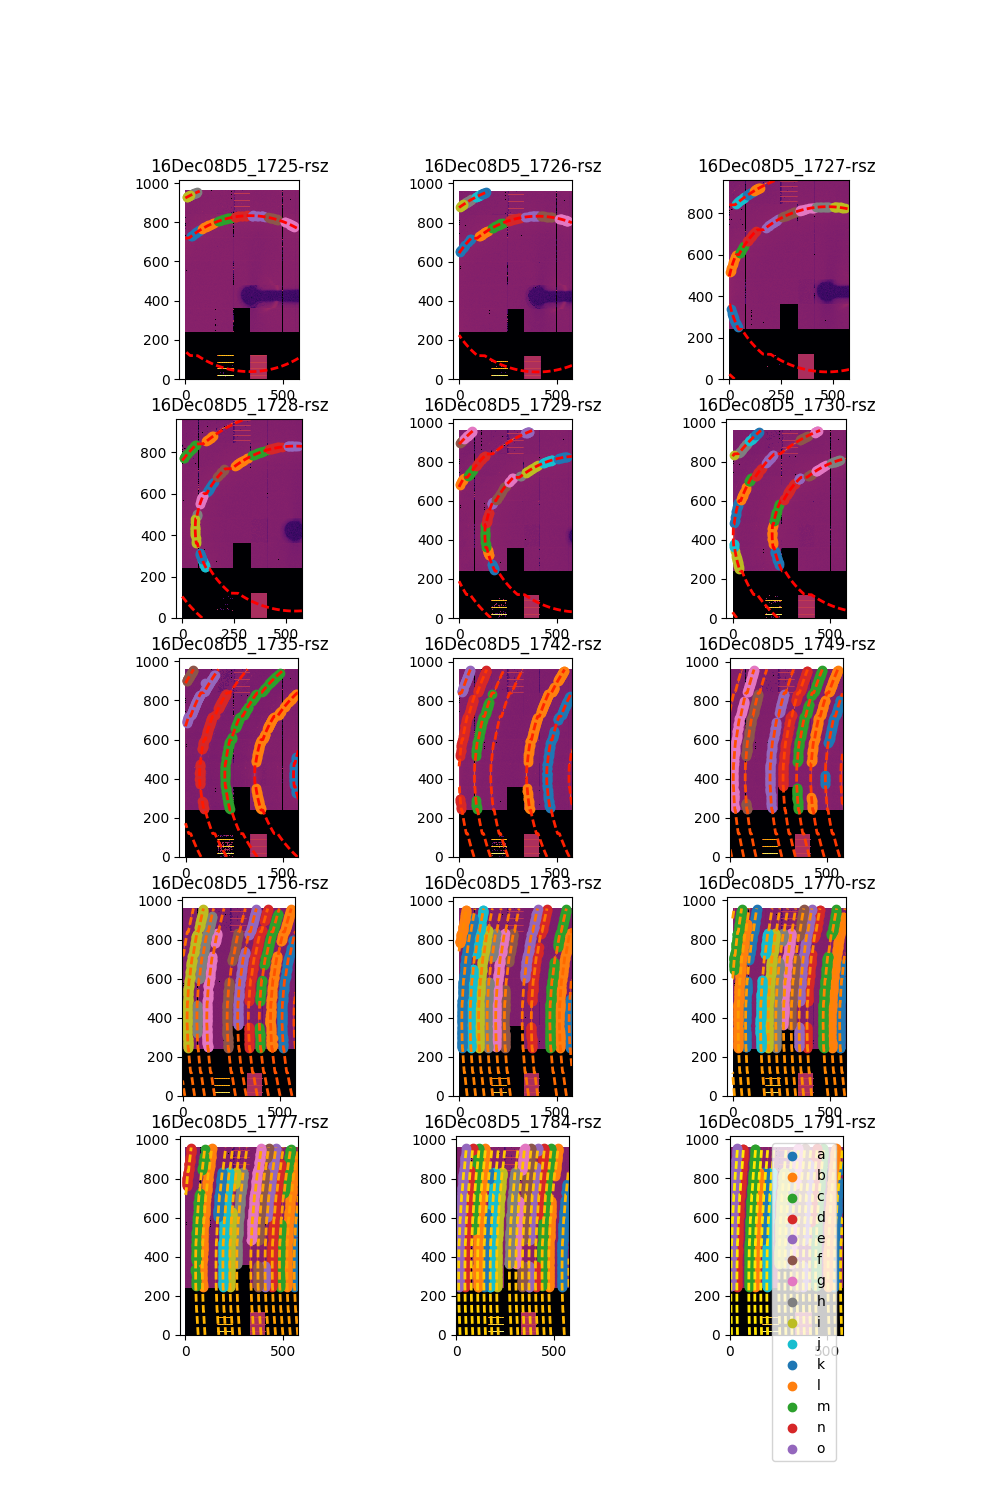

/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [9]:
width=3
height=int(ceil(len(gonioref.single_geometries)/width))
fig,ax = subplots(height, width,figsize=(10,15))
for idx, sg in enumerate(gonioref.single_geometries.values()):
    sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
    jupyter.display(sg=sg, ax=ax[idx//width, idx%width])

In [10]:
# Final pass of refinement with all constrains removed, very fine refinement

gonioref.bounds = None
gonioref.refine2("slsqp", eps=1e-13, maxiter=10000, ftol=1e-12)

Cost function before refinement: 1.98552255165e-08
     fun: 1.985509361568055e-08
     jac: array([  8.00710833e-09,   0.00000000e+00,   0.00000000e+00,
         5.40976121e-08,  -8.73568901e-07,   5.52556649e-09,
        -3.46690916e-05,  -5.57618995e-07])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([  5.20464974e-01,   6.34779274e-02,   4.46077058e-02,
         3.03313915e-03,   7.46909772e-03,  -1.21025274e-12,
        -1.74719009e-02,  -3.84262866e-04])
Cost function after refinement: 1.985509361568055e-08
GonioParam(dist=0.52046497446783402, poni1=0.063477927411335899, poni2=0.044607705770668513, rot1=0.0030331391530952758, rot2=0.0074690977188427727, rot3=-1.2102527436477782e-12, scale1=-0.017471900850864919, scale2=-0.00038426286588549689)
maxdelta on: scale1 (6) -0.0174719084444 --> -0.0174719008509


array([  5.20464974e-01,   6.34779274e-02,   4.46077058e-02,
         3.03313915e-03,   7.46909772e-03,  -1.21025274e-12,
        -1.74719009e-02,  -3.84262866e-04])

In [11]:
#Create a MultiGeometry integrator from the refined geometry:

angles = []
images = []
for sg in gonioref.single_geometries.values():
    angles.append(sg.get_position())
    images.append(sg.image)
    
multigeo = gonioref.get_mg(angles)
multigeo.radial_range=(0, 80)
print(multigeo)

MultiGeometry integrator with 15 geometries on (0, 80) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


<IPython.core.display.Javascript object>


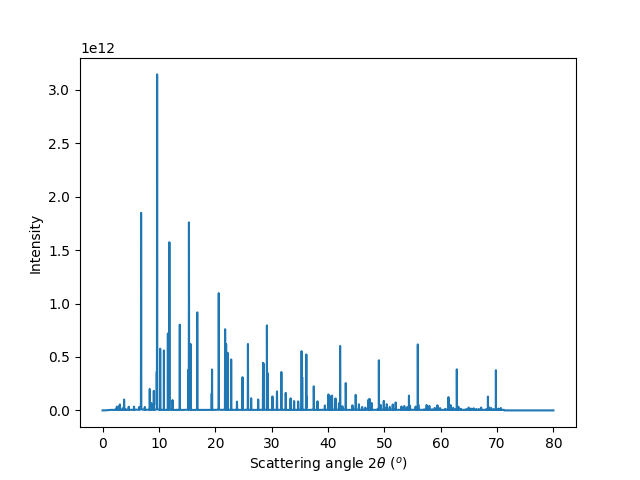

In [12]:
# Integrate the whole set of images in a single run:

res = multigeo.integrate1d(images, 10000)
fig, ax = subplots()
ax.plot(*res)
ax.set_xlabel(res.unit.label)
ax.set_ylabel("Intensity")


In [13]:
#Add hot pixels to the mask:

old_mask = d5.mask.astype("bool", copy=True)
new_mask = d5.mask.astype("bool", copy=True)

for ai,img in zip(multigeo.ais,images):
    b,a = ai.separate(img, 1000, restore_mask=0)
    b[old_mask] = 0
    b[b<0] = 0
    print(b.min(), b.max(),  b.mean(), b.std(), sum((b-b.mean())>10*b.std()))
    new_mask = numpy.logical_or(new_mask, (b-b.mean())>10*b.std())

print(sum(old_mask), sum(new_mask), sum(new_mask)-sum(old_mask))

    

0.0 15863268.2902 83.5177512541 23049.3683462 2
0.0 31799917.1707 121.935395627 43550.451975 2
0.0 40395675.8442 169.796982975 54981.4491103 3
0.0 44145524.3384 191.842623486 60562.994385 4
0.0 41667014.3133 203.059141682 58821.157906 4
0.0 41839615.3369 302.747985317 64784.4625963 4
0.0 46660674.3224 367.26974417 77381.3487766 4
0.0 33074351.2409 275.028948824 52439.1844162 4
0.0 33388873.3509 233.420007204 60792.6493 4
0.0 47050043.0628 239.782093207 83881.5570125 3
0.0 44919425.7354 179.632287256 72668.8738282 3
0.0 33156975.9154 97.7532467346 46120.6105461 3
0.0 42688504.1089 98.252340513 57692.9788378 3
0.0 25625142.5912 64.7399419021 34943.4875692 2
0.0 13236065.9962 42.7436073714 18796.20771 2
198678 198682 4


<IPython.core.display.Javascript object>


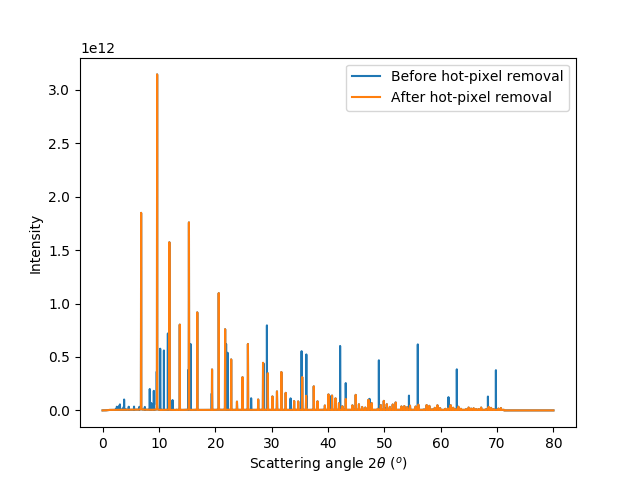

In [14]:
# Update the mask
for ai in multigeo.ais:
    ai.detector.mask = new_mask
    
# Integrate the whole set of images in a single run:
res2 = multigeo.integrate1d(images, 10000)
fig, ax = subplots()
ax.plot(*res, label="Before hot-pixel removal")
ax.plot(*res2, label="After hot-pixel removal")
ax.legend()
ax.set_xlabel(res.unit.label)
ax.set_ylabel("Intensity")

In [15]:
print("Total execution time", time.time()-start_time)

Total execution time 18.843876123428345
